[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/Ex03-Python_Machine_Learning.ipynb) 


# ADAMS Tutorial #3: Machine Learning in Python

The goal of the notebook is to revisit standard machine learning (ML) workflows as they were introduced in the Business Analytics and Data Science lecture. We will use the HMEQ credit scoring data sets from the last tutorial on [EDA using Pandas](https://github.com/Humboldt-WI/adams/blob/master/exercises/Ex02-Pandas-and-EDA.ipynb). As a quick reminder, the data is made available by [www.creditriskanalytics.net](http://www.creditriskanalytics.net/) and of 5960 observations and 13 variables. 

- BAD: 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

The modeling task is to predict the status of the target variable BAD from the other (independent) variables. 
<br> 
The notebook will elaborate on the process of different machine learning techniques and their evaluation, including logistic regression, random forest and gradient boosting. More specifically, our modeling pipeline, and agenda, is as follows:
1. Data integration
2. Logistic regression model
3. Evaluating predictive performance (resampling, confusion matrix, ROC)
4. Regularized logistic regression and grid-search
5. Ensemble learning using Random Forest and XGB
6. Feature importance analysis and model diagnosis

Quite a lot to do; let's get started.

In [1]:
# Import standard packages. We import modeling packages later when we first need them.
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data integration
Details on getting and loading the data were covered in [Tutorial #2](https://github.com/Humboldt-WI/adams/blob/master/exercises/Ex02-Pandas-and-EDA.ipynb). Check it out if unsure. 

In [2]:
# Load data
hmeq = pd.read_csv('/Users/aubrey/Documents/GitHub/adams_2021/Data sets for the tutorial notebooks-20210513/hmeq.csv') # add your path here

hmeq['BAD'] = hmeq['BAD'].astype('bool')
hmeq['LOAN'] = hmeq['LOAN'].astype(np.float64)

To prepare the data for modeling, we will encode categories using dummy variables and scale the numeric variables afer same basic treatment of outliers and missing values (repetition).

### Categorical variables
Our two categories are REASON and JOB. We first specify them as categories, then handle missing values, and then apply dummy coding; the only new bit.

A dummy variable is a binary vector that codes the values of one category level. For example, a vector for the variable 'JOB' and category level 'Office'. In this vector the value would  a 1 for every observation with an office job, and 0 for all others. 

We require dummy encoding because categorical data is common and carries valuable information but cannot be processed with some ML methods.

This can be clarified through the example of logistic regression. Regression analysis is common practice for using a continuous variable (e.g. 'LOAN') to predict the independent variable ('BAD' in this example). As you cannot rank and/or calculate a meaningful distance between categories, this interpretation is not possible. However, if we split up these variable into the earlier described dummy variables, we create a numeric variable by only using the number 0 and 1. The new variables will then be used as input for the categorical variable. In our case, we would have 6 different dummy variables for the variable 'JOB' as it had 6 categories. 

However, regression settings also have problems with multicollinearity. This means that if we incorporate all six new dummy variables, we will encounter a problem. If we would, the sum of the 6 vectors would result in the value 1 for every observation. If this is too abstract for you, let's look at this by using an example. One observation's (all other variables excluded) dummy variables for the category 'JOB'.

|  JOB_Mgr 	| JOB_Office  	| JOB_Other  	| JOB_ProfExe  	| JOB_Sales  	| JOB_Self  	|
|---	|---	|---	|---	|---	|---	|
|   0	|   0	|   0	|   0	|   0	|   1	|
 
    
However, the value 0 for all other categories ('Mgr', 'Office', 'Other', 'ProxExe' and 'Sales') already indicates that the job must be the category 'Self'. Therefore, one vector is redundant. And that is what multicollinearity is about. Multicollinearity is the high correlations among independent variables in a regression setting. Therefore, we can escape the so called dummy trap by dropping one dummy variable for each category. 

In [3]:
# Details for these operations are available in the EDA tutorial
cat_vars = ['REASON', 'JOB']
df = hmeq.copy()
# Convert from data type object to category
df[cat_vars] = df[cat_vars].apply(lambda x: x.astype('category'), axis=0)

# Add new category level for missing values
df[cat_vars] = df[cat_vars].apply(lambda x: x.cat.add_categories('IsMissing'), axis=0)

# Assing missing values to the new level
for c in cat_vars:
    df.loc[df[c].isna(),c] = "IsMissing"
    
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,True,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,True,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,True,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,True,1500.0,NaN,NaN,IsMissing,IsMissing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
# Dummy coding is easy to implement using Pandas or scikit-learn functions.
# We use the Pandas implementation. Make sure to take a look at the documentation. 
# The function is quite powerful. Any ideas how we could have simplified the above part? 
df = pd.get_dummies(df, prefix_sep="_", columns=cat_vars, drop_first=True)

# Note the new dummy columns and their naming
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BAD               5960 non-null   bool   
 1   LOAN              5960 non-null   float64
 2   MORTDUE           5442 non-null   float64
 3   VALUE             5848 non-null   float64
 4   YOJ               5445 non-null   float64
 5   DEROG             5252 non-null   float64
 6   DELINQ            5380 non-null   float64
 7   CLAGE             5652 non-null   float64
 8   NINQ              5450 non-null   float64
 9   CLNO              5738 non-null   float64
 10  DEBTINC           4693 non-null   float64
 11  REASON_HomeImp    5960 non-null   uint8  
 12  REASON_IsMissing  5960 non-null   uint8  
 13  JOB_Office        5960 non-null   uint8  
 14  JOB_Other         5960 non-null   uint8  
 15  JOB_ProfExe       5960 non-null   uint8  
 16  JOB_Sales         5960 non-null   uint8  


In [5]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_IsMissing
0,True,1100.0,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,1,0,0,1,0,0,0,0
1,True,1300.0,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,1,0,0,1,0,0,0,0
2,True,1500.0,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,1,0,0,1,0,0,0,0
3,True,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1
4,False,1700.0,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,1,0,1,0,0,0,0,0


### Numeric variables
For the numeric variables in the data, we will repeat the missing value and outlier treatment from the EDA tutorial. Thereafter, we use functionality of the scikit-learn library to scale numeric variables so that their value ranges are easier to compare.

#### Missing values

In [6]:
# Replace missing values among numeric variables using the median
for col in df.select_dtypes(include='float64').columns:
    if df[col].isna().sum() > 0:
        m = df[col].median()
        df[col].fillna(m, inplace=True)



#### Outliers

In [7]:
# Variables to be treated
num_cols = [x for x in df.columns if df[x].dtype in ['float64', 'float32', 'float16'] and x not in ['DEROG', 'DELINQ']]

# Calc 1st and 3rd quartile
q = df[num_cols].quantile([0.25, 0.75])
q

,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC
0.25,11100.0,48139.00,66489.50,3.0,117.371430,0.0,15.0,30.763159
0.75,23300.0,88200.25,119004.75,12.0,227.143058,2.0,26.0,37.949892


In [8]:
# Calc IQR (key is the .diff() function, the rest is mainly cleaning up data types/structure)
iqr = q.diff()
iqr.drop(iqr.index[0], inplace=True)
iqr = iqr.reset_index().iloc[:,1:len(num_cols)+1]
iqr

,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC
0,12200.0,40061.25,52515.25,9.0,109.771628,2.0,11.0,7.186733


In [9]:
# Values before truncation
df.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_IsMissing
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,18607.969799,73001.041812,101540.387423,8.756166,0.224329,0.405705,179.440725,1.170134,21.247819,34.000651,0.298658,0.042282,0.159060,0.400671,0.214094,0.018289,0.032383,0.046812
std,11207.480417,42552.726779,56869.436682,7.259424,0.798458,1.079256,83.574697,1.653866,9.951308,7.644528,0.457708,0.201248,0.365763,0.490076,0.410227,0.134004,0.177029,0.211254
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11100.000000,48139.000000,66489.500000,3.000000,0.000000,0.000000,117.371430,0.000000,15.000000,30.763159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23300.000000,88200.250000,119004.750000,12.000000,0.000000,0.000000,227.143058,2.000000,26.000000,37.949892,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Factor to determine outliers according to Tukey's rule
factor = 3
for c in num_cols:
    # upper outlier
    uo = (q.loc[0.75,c] + iqr[c]*factor)
    # lower outliers
    lo = (q.loc[0.25,c] - iqr[c]*factor)
    # Truncation
    df.loc[ df[c] > uo[0], c ] = uo[0]
    df.loc[ df[c] < lo[0], c ] = lo[0]

# Examines descriptives one more time
df.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_IsMissing
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,18459.177852,72326.504060,100527.982473,8.755159,0.224329,0.405705,179.014539,1.148322,21.235906,33.919411,0.298658,0.042282,0.159060,0.400671,0.214094,0.018289,0.032383,0.046812
std,10500.744330,39437.327495,50639.354946,7.255089,0.798458,1.079256,80.768529,1.538720,9.901447,6.568137,0.457708,0.201248,0.365763,0.490076,0.410227,0.134004,0.177029,0.211254
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.202962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11100.000000,48139.000000,66489.500000,3.000000,0.000000,0.000000,117.371430,0.000000,15.000000,30.763159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23300.000000,88200.250000,119004.750000,12.000000,0.000000,0.000000,227.143058,2.000000,26.000000,37.949892,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,59900.000000,208384.000000,276550.500000,39.000000,10.000000,15.000000,556.457943,8.000000,59.000000,59.510090,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Scaling variable values
Finally we can proceed with scaling variable values. Remeber that treating outliers before this step was important because the extreme values would otherwise impede the scaling. We will use the scaler class of scikit-learn to carry out the actual scaling. scikit-learn features multiple classes for different types of scaling. Their use is always the same and consistent with our example. 


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # this class standardizes the data

X = df.select_dtypes(include='float64')  # extract numeric variables
X_new = scaler.fit_transform(X)  # perform the scaling
X_new = pd.DataFrame(X_new, columns = X.columns)  # convert result into a data frame
df[X.columns] = X_new

df.head(10)

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_IsMissing
0,True,-1.653277,-1.178335,-1.214631,0.240519,-0.280976,-0.375943,-1.048118,-0.096401,-1.235873,0.136862,1,0,0,1,0,0,0,0
1,True,-1.634229,-0.057653,-0.634500,-0.241941,-0.280976,1.477341,-0.708023,-0.746347,-0.730854,0.136862,1,0,0,1,0,0,0,0
2,True,-1.615181,-1.491770,-1.655531,-0.655479,-0.280976,-0.375943,-0.365865,-0.096401,-1.134869,0.136862,1,0,0,1,0,0,0,0
3,True,-1.615181,-0.185310,-0.223017,-0.241941,-0.280976,-0.375943,-0.068694,-0.096401,-0.124831,0.136862,0,1,0,0,0,0,0,1
4,False,-1.596133,0.645978,0.226563,-0.793325,-0.280976,-0.375943,-1.060913,-0.746347,-0.730854,0.136862,1,0,1,0,0,0,0,0
5,True,-1.596133,-1.059453,-1.189056,0.033750,-0.280976,-0.375943,-0.960214,-0.096401,-1.336877,0.486359,1,0,0,1,0,0,0,0
6,True,-1.586609,-0.600433,-0.858910,-0.517633,3.476581,1.477341,-1.261916,-0.096401,-0.427843,0.136862,1,0,0,1,0,0,0,0
7,True,-1.586609,-1.111338,-1.135457,0.309442,-0.280976,-0.375943,-1.117466,-0.746347,-1.336877,0.451533,1,0,0,1,0,0,0,0
8,True,-1.567561,-1.004881,-1.062267,-0.793325,-0.280976,1.477341,0.469514,-0.096401,-0.932862,0.136862,1,0,0,1,0,0,0,0
9,True,-1.567561,-0.185310,-0.755957,0.998671,-0.280976,-0.375943,-0.782729,-0.746347,-0.831858,0.136862,1,0,0,0,0,1,0,0


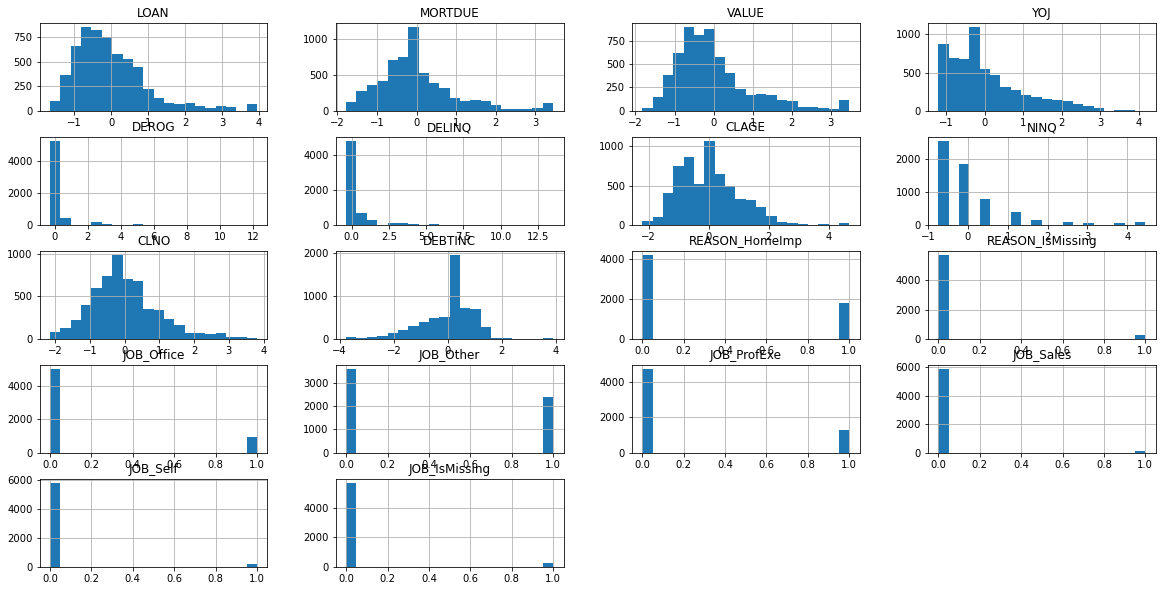

In [12]:
# Verify that our data set looks fine
plt.rcParams["figure.figsize"] = (20,10)
df.select_dtypes(exclude='bool').hist(bins=20);
# ok, we can easily spot a couple of remaining issue but let's start the actual modeling

We will now move on with some modeling. Many relevant modeling functions expect an input in the form $(y, X)$, where $y$ denotes the target variable and $X$ the covariates. We build these items from our prepared data frame and use them in the reminder.   

In [13]:
y = df.BAD
X = df.drop('BAD', axis=1)

## 2. Logistic regression model
The first model that we will consider is the logistic regression or logit model. 

Since we face a classification problem, we are looking for a probability of a certain outcome, that is $p \left( y=BAD|x \right)$, where *p* stands for probability. Remember the well-known logistic regression formula:

$$y=ln(\frac{p}{1-p})=\beta_{0}+\beta_{1}X_{1}+\beta_{2}X_{2}+...+\beta_{k}X_{k},$$

which we could also represent in matrix form as follows:

$$Y=g \left( WX+b \right) $$

where the W stands for the **weight** matrix, containing coefficients/betas for respective explanatory 
variables, and b is an error term or a **bias**. In the case of the logit model, the nonlinear function $g(\cdot)$ is chosen to be the logistic function: $ g(z) = \frac{1}{1+e^{-z}}$.

Logistic regression is a popular model for both, explanatory and predictive modeling. If you have an explanatory use case, you should use the implementation in the *statsmodels* library. This libraray provides standard functionality like statistical hypothesis testing and gives us the well-known regression table as output. 

In [15]:
!conda install -y --prefix {sys.prefix} statsmodels
import statsmodels.api as sm
logit_model = sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Solving environment: done

## Package Plan ##

  environment location: /Users/aubrey/opt/anaconda3

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    statsmodels-0.13.2         |   py38hca72f7f_0         8.4 MB
    ------------------------------------------------------------
                                           Total:         8.4 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/osx-64::patsy-0.5.2-py38hecd8cb5_1
  statsmodels        pkgs/main/osx-64::statsmodels-0.13.2-py38hca72f7f_0



statsmodels-0.13.2   | 8.4 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Optimization terminated successfully.
         Current function value: 0.412766
         Iterations 7
                           Logit Regression Results        

Later we will revisit the logit model and use the implementation in *scikit-learn*. It is more geared toward predictive modeling, which is the topic of the reminder of the notebook.

## 3. Evaluating predictive performance (resampling, confusion matrix, ROC)
Performance evaluation involves practices to simulate an application of a model and accuracy indicators to capture how well it predicts. 

We build a model on our data. But how do we ensure, that our model finds generalizable patterns in the data as opposed to just describing this particular sample. 

### Data organization

The most simple approach is to build a model on the whole data set. This is what we did above. We could use the same data to make predictions and assess their accuracy. However, this would greatly overestimate model formance. Rather, we split the data into training and test set. This means, we train a model on a random subset of our data set, the training set. Then we use the remaining instances, the test set, also called hold out data, for model assessment. In order to evaluate the performance, we compute predictions of the test set with the model built on the training set. We compare these predictions to the actuals in the test set. Let's see how scikit-learn supports this workflow.

In [16]:
# Data partitioning
from sklearn.model_selection import train_test_split

# create training and test set
# x_train = all columns but 'BAD' of training set (needed to build supervised learning model)
# y_train = outcome variable of training observations (needed to build supervised learning model)
# x_test = all columns but 'BAD' of test set (needed to predict outcome of test set with training set model)
# y_test = outcome variable of test observations (needed for model assessment)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )  # 20% of the data as hold-out

#make yourself familiar with these vectors
y_train.shape, y_test.shape, x_train.shape, x_test.shape

((4768,), (1192,), (4768, 18), (1192, 18))

We will now re-estimate the logit model. However, we use the scikit-learn version this time (for illustration) and make sure to not touch the test set. 

In [17]:
from sklearn.linear_model import LogisticRegression

sk_logit = LogisticRegression(penalty='none', fit_intercept=True, max_iter=500)
log = sk_logit.fit(x_train, y_train)
print(log)

# Calculate classification accuracy on the training and the test set
print('Accuracy on train data: {:.4f}'.format(sk_logit.score(x_train, y_train)))
print('Accuracy on test data: {:.4f}'.format(sk_logit.score(x_test, y_test)));

LogisticRegression(max_iter=500, penalty='none')
Accuracy on train data: 0.8402
Accuracy on test data: 0.8398


### Performance assessment

Accuracy indicators help us evaluate how well our model predicts the target. We compute them by comparing actuals to  predictions. This is also what the function *.score* has done in the above print statement. 


#### Classification accuracy and its shortcomings
Classification accuracy is a threshold metric. It calculates model performance for one threshold or classification cut-off. If not specified, this threshold is usually set to 0.5. Changing the threshold can change the accuracy a lot, eventhough the model stays the same. This is particularly true in imbalanced data sets like this one. Let me give you an examplary scenario: We have 100 observations. 5 observations are of the class 'BAD' and 95 of the class 'GOOD'. So even without finding any generalizable patterns, classifying all observations as good would still result in an accuracy of 95%. To ensure robustness of our model, we want to avoid this. 

In our case, the accuracy is just under the accuracy of the training data. We've included both for comparison and as it can be a first indicator for overfitting (high score on training data, low on test). In our case however, it looks acceptable, which makes sense because logit is not prone to overfitting.

A preferable approach to assess classification performance is to consider all possible thresholds. This is what receiver-operating-characteristics (ROC) analysis does. We looking into ROC, let's have a look at the full confusion table first, which will also remind us of the role of the threshold.


#### Confusion matrix

In [18]:
from sklearn import metrics  # Important lib where we find various performance measures

# 1. Quick and dirty way to get a confusion table
cmat = metrics.confusion_matrix(y_test, sk_logit.predict(x_test))
print(cmat)

[[930  20]
 [171  71]]


/Users/aubrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


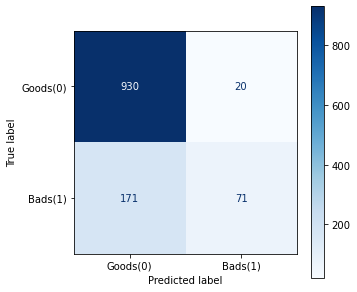

In [19]:
# 2. Pretty-print confusion matrix
plt.rcParams["figure.figsize"] = (5,5)
metrics.plot_confusion_matrix(sk_logit, x_test, y_test, labels=[0, 1], display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Classification accuracy simply calculates the number of correct class predictions (main diagonal) over all cases. Here, what class a model predicts depends on the classification threshold. You classify cases as BAD if $p(y=BAD|x) \gt \tau$, where $\tau$ denotes the threshold. 

Hence, the above confusion table is based on one threshold, and might look rather different for another. A ROC curve consideres all cut-offs $\tau \in [0,1]$ plotting the True Positive Rate and False Positive Rate for each threshold. 

#### ROC Curve and AUC

This is one of the most important evaluation metrics in classification analysis. Have a look at the graph below. The curve tells us how well the model differntiates the two classes, in regards to their predicted probabilities.
A ROC curve has the FPR on the X-axis and FPR on the Y-axis.
The curve is made up out of all the different combinations of TPR and FPR across all thresholds.

The AUC stand for the Area under the Curvea and is a ranking indicator. The AUC estimates the probability that a randomly chosen positive instance is correctly ranked higher than a randomly chosen negative (Hanley and McNeil, 1983) . We calculate this area, as our goal is to have a FPR of 0 and a TPR of 1. This would be the perfect model. This point is in the top right corner of a ROC Curve. So the closer we get to that point, the better the model and the bigger the area under it. It is common practice to add a horizontal line to the plot. You can show that this line corresponds to a random classifier. So any serious model should give a ROC curve (much) above the horizontal line. This also implies that a classifier should display AUC (much) bigger than 0.5.


Below we show different way to plot the ROC curve.

/Users/aubrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


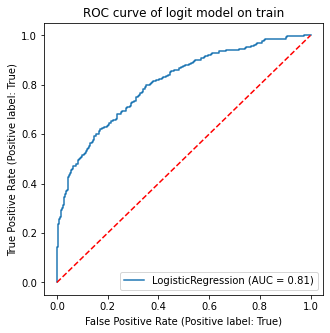

In [20]:
# Scikit-learn offers an easy-to-use function to produce a ROC curve. 
metrics.plot_roc_curve(log, x_test, y_test)
plt.title('ROC curve of logit model on train')
plt.plot([0, 1], [0, 1], "r--");  # the random benchmark we need to add manually

If you want a little more control, for example to depict the training and test set results in one chart, you can proceed as follows: 

In [21]:
# Example how to 'manually' plot the ROC curve
yhat_logit = log.predict_proba(x_test)[:, 1]

/var/folders/44/70m2m32s00qchf6kxd4frx6m0000gn/T/ipykernel_35756/2902853727.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr_tr, tpr_tr, "b", label="Train Set= %0.4f" % auc_tr, color='green')


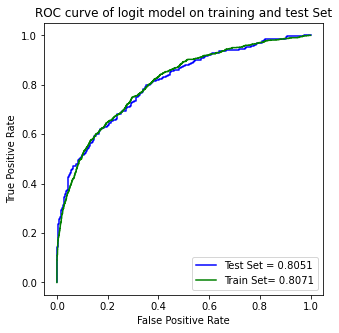

In [22]:
fpr, tpr, _ = metrics.roc_curve(y_test, yhat_logit)  # extracting FPR and TPR for the test set
fpr_tr, tpr_tr, _ = metrics.roc_curve(y_train, log.predict_proba(x_train)[:, 1])  # same for the training set

# Compute AUC
auc = metrics.auc(fpr, tpr) 
auc_tr = metrics.auc(fpr_tr, tpr_tr)

# ROC curve:
# Test data
plt.plot(fpr, tpr, "b", label="Test Set = %0.4f" % auc)
# Training data
plt.plot(fpr_tr, tpr_tr, "b", label="Train Set= %0.4f" % auc_tr, color='green')
# Random benchmark
plt.legend(loc="lower right")
# Plot configuration
plt.title('ROC curve of logit model on training and test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [23]:
# Since we are about to compute many models, let's keep track of auc results using a dictionary
auc_trace = {'logit':auc}
auc_trace

{'logit': 0.8051283166594172}

#### Cross-validation (model simulation)

Cross validation is an extendend approach of the split sample method. It consists of repeating the split sample method multiple times.

Step by step:
- Randomly split data in N disjoint folds (E.g., N=5) 
- Build model on N-1 folds and validate that model on thw remaining fold 
- Apply trained model to predict cases in the validation sample (hold-out data) 
- Measure model performance 
- Repeat N times and average 
- Average model performance over validation folds gives performance estimate 
- Can also estimate standard deviation (e.g., for statistical hypothesis testing)

The following example is rather detailed and meant to show you the intermediate steps in a cross-validation process. Later, we will simplify cross-validation using convenience functions of sklearn.

Cross-validating the logit model:
	CV iter: 0 with AUC=0.7549302816510194
Average AUC on test set during cross-validation: 0.7549
	CV iter: 1 with AUC=0.8082942959492974
Average AUC on test set during cross-validation: 0.7816
	CV iter: 2 with AUC=0.8172223753100027
Average AUC on test set during cross-validation: 0.7935
	CV iter: 3 with AUC=0.8260953430697162
Average AUC on test set during cross-validation: 0.8016
	CV iter: 4 with AUC=0.7766051253788925
Average AUC on test set during cross-validation: 0.7966
	CV iter: 5 with AUC=0.8293744833287406
Average AUC on test set during cross-validation: 0.8021
	CV iter: 6 with AUC=0.7664094791953706
Average AUC on test set during cross-validation: 0.7970
	CV iter: 7 with AUC=0.83689721686415
Average AUC on test set during cross-validation: 0.8020
	CV iter: 8 with AUC=0.8067840035646654
Average AUC on test set during cross-validation: 0.8025
	CV iter: 9 with AUC=0.7968419293750697
Average AUC on test set during cross-validation: 0.8019


InvalidIndexError: (slice(None, None, None), None)

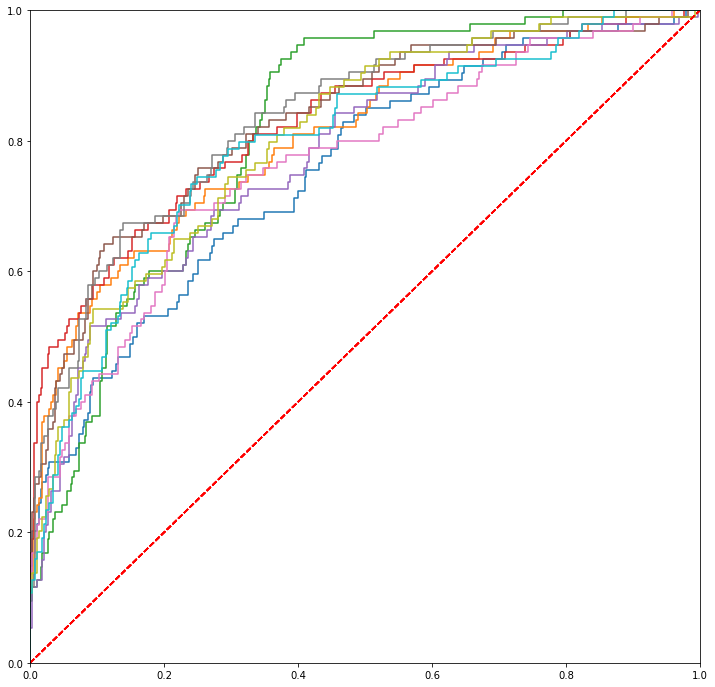

In [32]:
from sklearn.model_selection import StratifiedKFold

# Setup cross-validation and data structures to store results
nfold = 10
resultscv = list()
cv = StratifiedKFold(n_splits=nfold)
cv_auc_test = np.zeros(nfold)
cv_auc_test[cv_auc_test == 0] = 'nan' #for now, to avoid 0 values to be taken into account for, help ? average
cv_auc_train = np.zeros(nfold)
fpr_cv = {}
tpr_cv= {}
thresholds = {}

# Configure the plot we are about to create 
plt.figure(figsize=[12,12])
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])

print('Cross-validating the logit model:')
for i, (tr_idx, vl_idx) in enumerate(cv.split(x_train, y_train)):
    xtr, xvl = x_train.iloc[tr_idx], x_train.iloc[vl_idx]
    ytr, yvl = y_train.iloc[tr_idx], y_train.iloc[vl_idx]
    sk_logit.fit(xtr, ytr)
    temp = sk_logit.predict_proba(xvl)[:, 1]
    fp_rate_cv, tp_rate_cv, threshold = metrics.roc_curve(yvl, temp.astype('float'))
    thresholds[i] = threshold
    fpr_cv[i] = fp_rate_cv
    tpr_cv[i] = tp_rate_cv
    cv_auc_test[i] = metrics.auc(fp_rate_cv, tp_rate_cv)
    print('\tCV iter: {} with AUC={}'.format(i, cv_auc_test[i]))
    print('Average AUC on test set during cross-validation: {:.4f}'.format(np.nanmean(cv_auc_test)))
    
    # Print ROC curve
    plt.plot(fp_rate_cv,tp_rate_cv)
    plt.plot([0, 1], [0, 1], "r--")
    
    #save training performance for evaluation
    temp=sk_logit.predict_proba(xtr)[:, 1]
    fp_rate, tp_rate, _ = metrics.roc_curve(ytr, temp.astype('float'))
    cv_auc_train[i] = metrics.auc(fp_rate, tp_rate)

mean_fp_rate_cv = pd.DataFrame(np.vstack(fp_rate_cv))
mean_tp_rate_cv = pd.DataFrame(np.vstack(tp_rate_cv))

plt.plot(mean_fp_rate_cv, mean_tp_rate_cv, color='black')    
plt.show()

In [25]:
auc_trace.update( {'logit_cv' : np.mean(cv_auc_test)})
print('Avg. auc = {:f}({:f})'.format(np.mean(cv_auc_test), np.std(cv_auc_test)))

Avg. auc = 0.801945(0.026449)


## 4. Regularized logistic regression and grid-search

Regularization is a method that aims to avoid overfitting. Complex models tend to show a high variance. Model complexity and bias are closely connected (low complexity -> high bias and vice versa). Introducing bias can help prevent overfitting, as it reduced variance. This is done by adding a complexity penatly. 

In a regression setting, large coefficients are indicators of complex, unstable models. Possible causes include high dimensionality and multicollinearity. The aim of the model is to minimize the magnitude the coefficients have on the model. Therefore, it is included in the loss function. 

$$ 𝜷←min⁡ℒ(𝜷)+𝜆||(𝜷)||{_1} $$

This penatly produces sparser models, as it forces the coefficients to zero. Furthermore, we also have a new metaparameter $𝜆$ (equivalent to as 'C' in the code below), which requires tuning. Therefore, we use a grid search to identify its best setting. The higher $𝜆$ , the higher the penalty for complexity.

In [41]:
# Trying to improve performance using regularized logit
lasso = LogisticRegression(penalty='l1', C=0.1, fit_intercept=True, max_iter=200, solver='liblinear')
lasso.fit(x_train, y_train)
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, lasso.predict_proba(x_test)[:, 1])
auc_trace.update( {'lasso' : metrics.auc(fp_rate, tp_rate)} )
print('Lasso test set AUC: {:.4f}'.format(auc_trace['lasso'] ))

Lasso test set AUC: 0.8232


#### Meta-parameter tuning

Meta-paramters are those that we have to choose before building a model, just as the complexity meta-parameter in the regularized logistic regression. Different learners exhibit different meta-parameters. Tuning (some of) these is often beneficial and grid-search is a versatile approach to do so. Grid-search specifies different values for each meta-parameter and evaluating all possible combinations of meta-parameters in the search grid.
Let's try to improve the LASSO model by tuning its meta-parameter.

In [42]:
# Try finding a better setting for penalty parameter C using grid search
from sklearn.model_selection import GridSearchCV

penalty_settings = {'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 2, 3, 3, 4, 5, 10, 20, 22, 24, 26, 28, 30, 32, 34, 36]}
print('Grid-searching regularization parameter')
gs_lasso = GridSearchCV(lasso, penalty_settings, scoring='roc_auc', refit=True, cv=nfold)
gs_lasso.fit(x_train, y_train)

# Find test set auc of the best lasso model
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_lasso.predict_proba(x_test)[:, 1])
auc_trace.update( {'lasso_gs' : metrics.auc(fp_rate, tp_rate)} )
print('Lasso test set AUC with best paramter: {:.4f}'.format(auc_trace['lasso_gs']))

Grid-searching regularization parameter
Lasso test set AUC with best paramter: 0.8242


In [250]:
# Which was the best penalty?
gs_lasso.best_params_

{'C': 3}

## 5. Ensemble learning using Random Forest and XGB
Both regularized regression show a slight improvement in our predictions. But can we do more?



### Random Forest

The random forest algorithm is an ensemble algorithm. It uses many base models (decision trees) and predicts the target variable by averaging their predictions. The base model trees are grown from bootstrap samples of the training set(random samples with replacement) and different random sample of attributes (random subspace). This means instead of using all observations and features in our data, we build a variety of models on smaller subsets of both the data AND the attributes. This allows the algorithms to pick up on more rules, as it forces models to find rules only based on the given subset of attributes. This way we might discover rules that a normal model would overshadow. This happens when one attribute has a high impact on the outcome variable.

<br>

#### Meta-parameters in our grid search
Random forest is often considered robust toward meta-parameter settings. Still, some tuning may be beneficial. We consider the following meta-parameters. 
<br>
n_estimators: number of trees(models) in forest (ensemble)<br>
max_features : maximum features in random subspace<br>

There are a couple of more meta-parameters. Normally, you would not need to tune them but for the sake of completeness, here are some more meta-parameters:<br> <br>
min_samples_split: minimum number of samples required in leaf node before another split is made. If it is less, this node wont split.<br>
min_samples_leaf: minimum number of samples required to be at a leaf node.<br>
max_leaf_nodes: maximum number of leaf nodes in a tree<br>
criterion: splitting function to use, e.g. gini coefficient<br>
max_depth: pruning parameter, maximum depth of decision tree<br>
n_jobs: parallelization of model building<br>
random_state:
This parameter is used to define the random selection.
It is used for comparison between various models.<br><br>

If meta-parameters are not specified, they will be set to their default. 

**Remark**: Tuning RF might take a while. If you want to speed things up, consider setting the meta-parameter *max_samples*. It allows you to control the size of the bootstrap sample from which each tree is grown. Read the documentation for more information. Smaller sample sizes accelerate the training.

In [43]:
from sklearn.ensemble import RandomForestClassifier
# Performance of tree-based ensemble algorithms in the form of random forest

print('Tuning random forest classifier')
rf = RandomForestClassifier(random_state=123, max_samples = 0.5)  # This way, bootstrap sample size will be 50% of the training set

# Define meta-parameter grid of candidate settings
# The following settings are just for illustration
param_grid = {'n_estimators': [100, 200, 500],
              'max_features': [1, 2, 4]
              }

# Set up the grid object specifying the tuning options
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_rf.fit(x_train, y_train)
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)

# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_rf.predict_proba(x_test)[:, 1])
auc_trace.update( {'rf' : metrics.auc(fp_rate, tp_rate)}) 
print('RF test set AUC: {:.4f}'.format(auc_trace['rf']))


Tuning random forest classifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.0min finished


Best CV AUC: 0.9780
Optimal RF meta-parameters:
{'max_features': 1, 'n_estimators': 500}
RF test set AUC: 0.9850


You should see some quite impressive AUC value. Let's plot the ROC curve to appreciate the power of our RF. This also shows how to access the final model from the grid-search results.

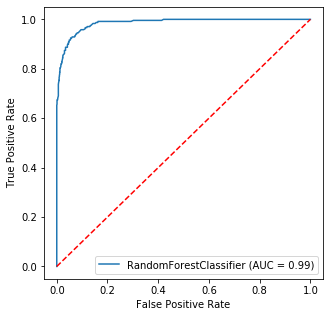

In [44]:
# The plot is not new but note the use of gs_rf.best_estimator_ 
metrics.plot_roc_curve(gs_rf.best_estimator_, x_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

# XGBoost


XGBoost (Extreme Gradient Boosting) is a state-of-the-art algorithm. It builds an ensemble iteratively by fitting weak learners (typically shallow trees) to correct the errors of the current models. Error correction is implemented via gradient descent. As such, the learning rate is one out of several meta-parameters we need to consider when building an XGB classifier.

Note that different implementations of XGB are available in Python. We demonstrate XGB using the *xgboost* library, which is very popular. Using the scikit-learn version is simpler but might not incorporate all the features of XGB. 

In [46]:
import xgboost as xgb
    
# XGBoost module recommends storing data in a different manner
#DM_train = xgb.DMatrix(data=x_train, label=y_train)
#DM_test = xgb.DMatrix(data=x_test, label=y_test)

# Setting up the grid of meta-parameters
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.5, 0.9, 5),  # random subspace
    'n_estimators': [100, 200],  # ensemble size or number of gradient steps
    'max_depth': [5, 10],   # max depth of decision trees
    'learning_rate': [0.1, 0.01],  # learning rate
    'early_stopping_rounds': [10]}  # early stopping if no improvement after that many iterations

gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=1)
gs_xgb.fit(x_train, y_train)
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)

# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_xgb.predict_proba(x_test)[:, 1])
auc_trace.update( {'xgb' : metrics.auc(fp_rate, tp_rate)})
print('XGB test set AUC with optimal meta-parameters: {:.4f}'.format( auc_trace['xgb'] ))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.1min finished


Best CV AUC: 0.9610
Optimal XGB meta-parameters:
{'colsample_bytree': 0.5, 'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
XGB test set AUC with optimal meta-parameters: 0.9652


The XGB models completes our journey through the space of learning algorithms. We have covered the maybe most important learners; of course albeit neural networks, which will be our focus in many subsequent tutorials. Let's have a final look at the AUC results we obtained:

In [47]:
auc_trace

{'logit': 0.8226520962211382,
 'logit_cv': 0.7987730508610645,
 'lasso': 0.8231965122252127,
 'lasso_gs': 0.8241755829422173,
 'rf': 0.9850307551137785,
 'xgb': 0.9652451847721575}

The AUC results justify two conclusions. First, the data exhibits a strong signal. This follows from the overall high level of AUC performance. The remarkable differences between linear and nonlinear classifiers further suggests that the feature-response relationship is nonlinear. To shed some light on this relationship, the last part of the tutorial revisits two popular approaches in the scope of interpretable machine learning, permutation-based feature importance and partial dependence.  

## 6. Feature importance analysis and model diagnosis

Interpretability of machine learning models is a big topic, because usually, the more complicated the model, the harder it will be to understand how our final predictions are computed. Especially for so called black-box models, methods have been develop to understand the importance of specific features in these models. 

### Permutation-based feature importance

Permuation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. In order to do this, we permute one variable by shuffling its values across all observations. This means, each observation will receive a new value. This permutation breaks the relationship to the target variable. Then we make an assumption: the higher the increase of the error due to the permutation, the more important this variable was in building the model. This way we can compute a ranking. 

Let's give it a try using our Random Forest model.

Computing permutation-based feature importance...


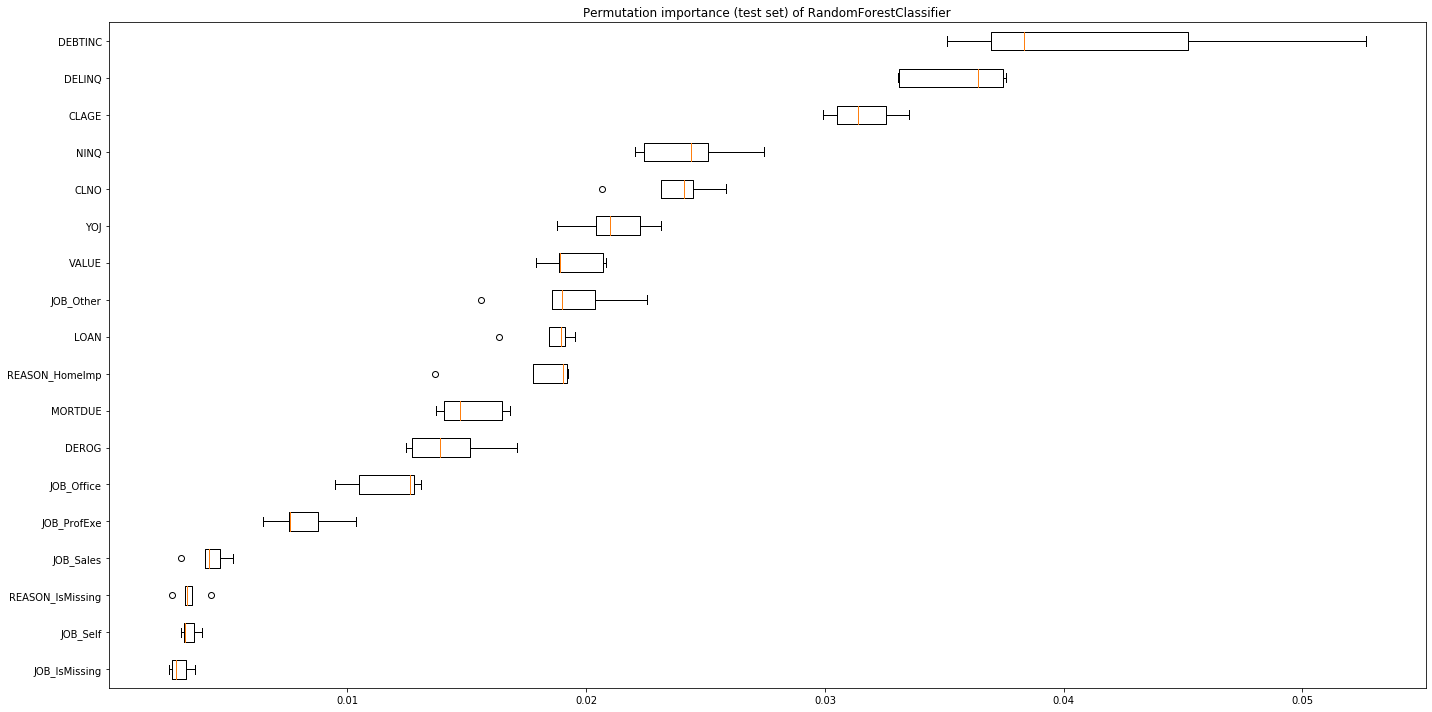

In [257]:
plt.rcParams['figure.figsize'] = 20, 10

# Permutation-based feature importance
print('Computing permutation-based feature importance...')
from sklearn.inspection import permutation_importance

classifier = gs_rf.best_estimator_

perm_imp = permutation_importance(classifier, x_test, y_test, scoring='roc_auc', random_state=123)
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation importance (test set) of {}".format(str(classifier)[0:str(classifier).find('(')]))
fig.tight_layout()
plt.show()


The result agrees with domain knowledge. The debt-to-income ration proves very important. RF devotes much attention to this feature so that permuting it increases the prediction error. High importance of the number of delinquent credit lines (DELINQ) also makes sense. For CLAGE, the age of the oldest credit line in months it is maybe less obvious how it affects the target. Specifically, it would be useful to check whether high/lower values in this feature are associated with higher/lower default probability. We do not get such insight from permutation-based feature importance analysis. But partial-dependence should give as an answer.

### Partial dependence plot (PDP)
A PDP shows what type of effect a feature has on predicted probabilities. A PDP plots the values of a chosen variable (on the x-axis) against model-estimated probabilities (on the y-axis) whilst acconding for the combined effect of all other features. 

Computing partial dependence plots...


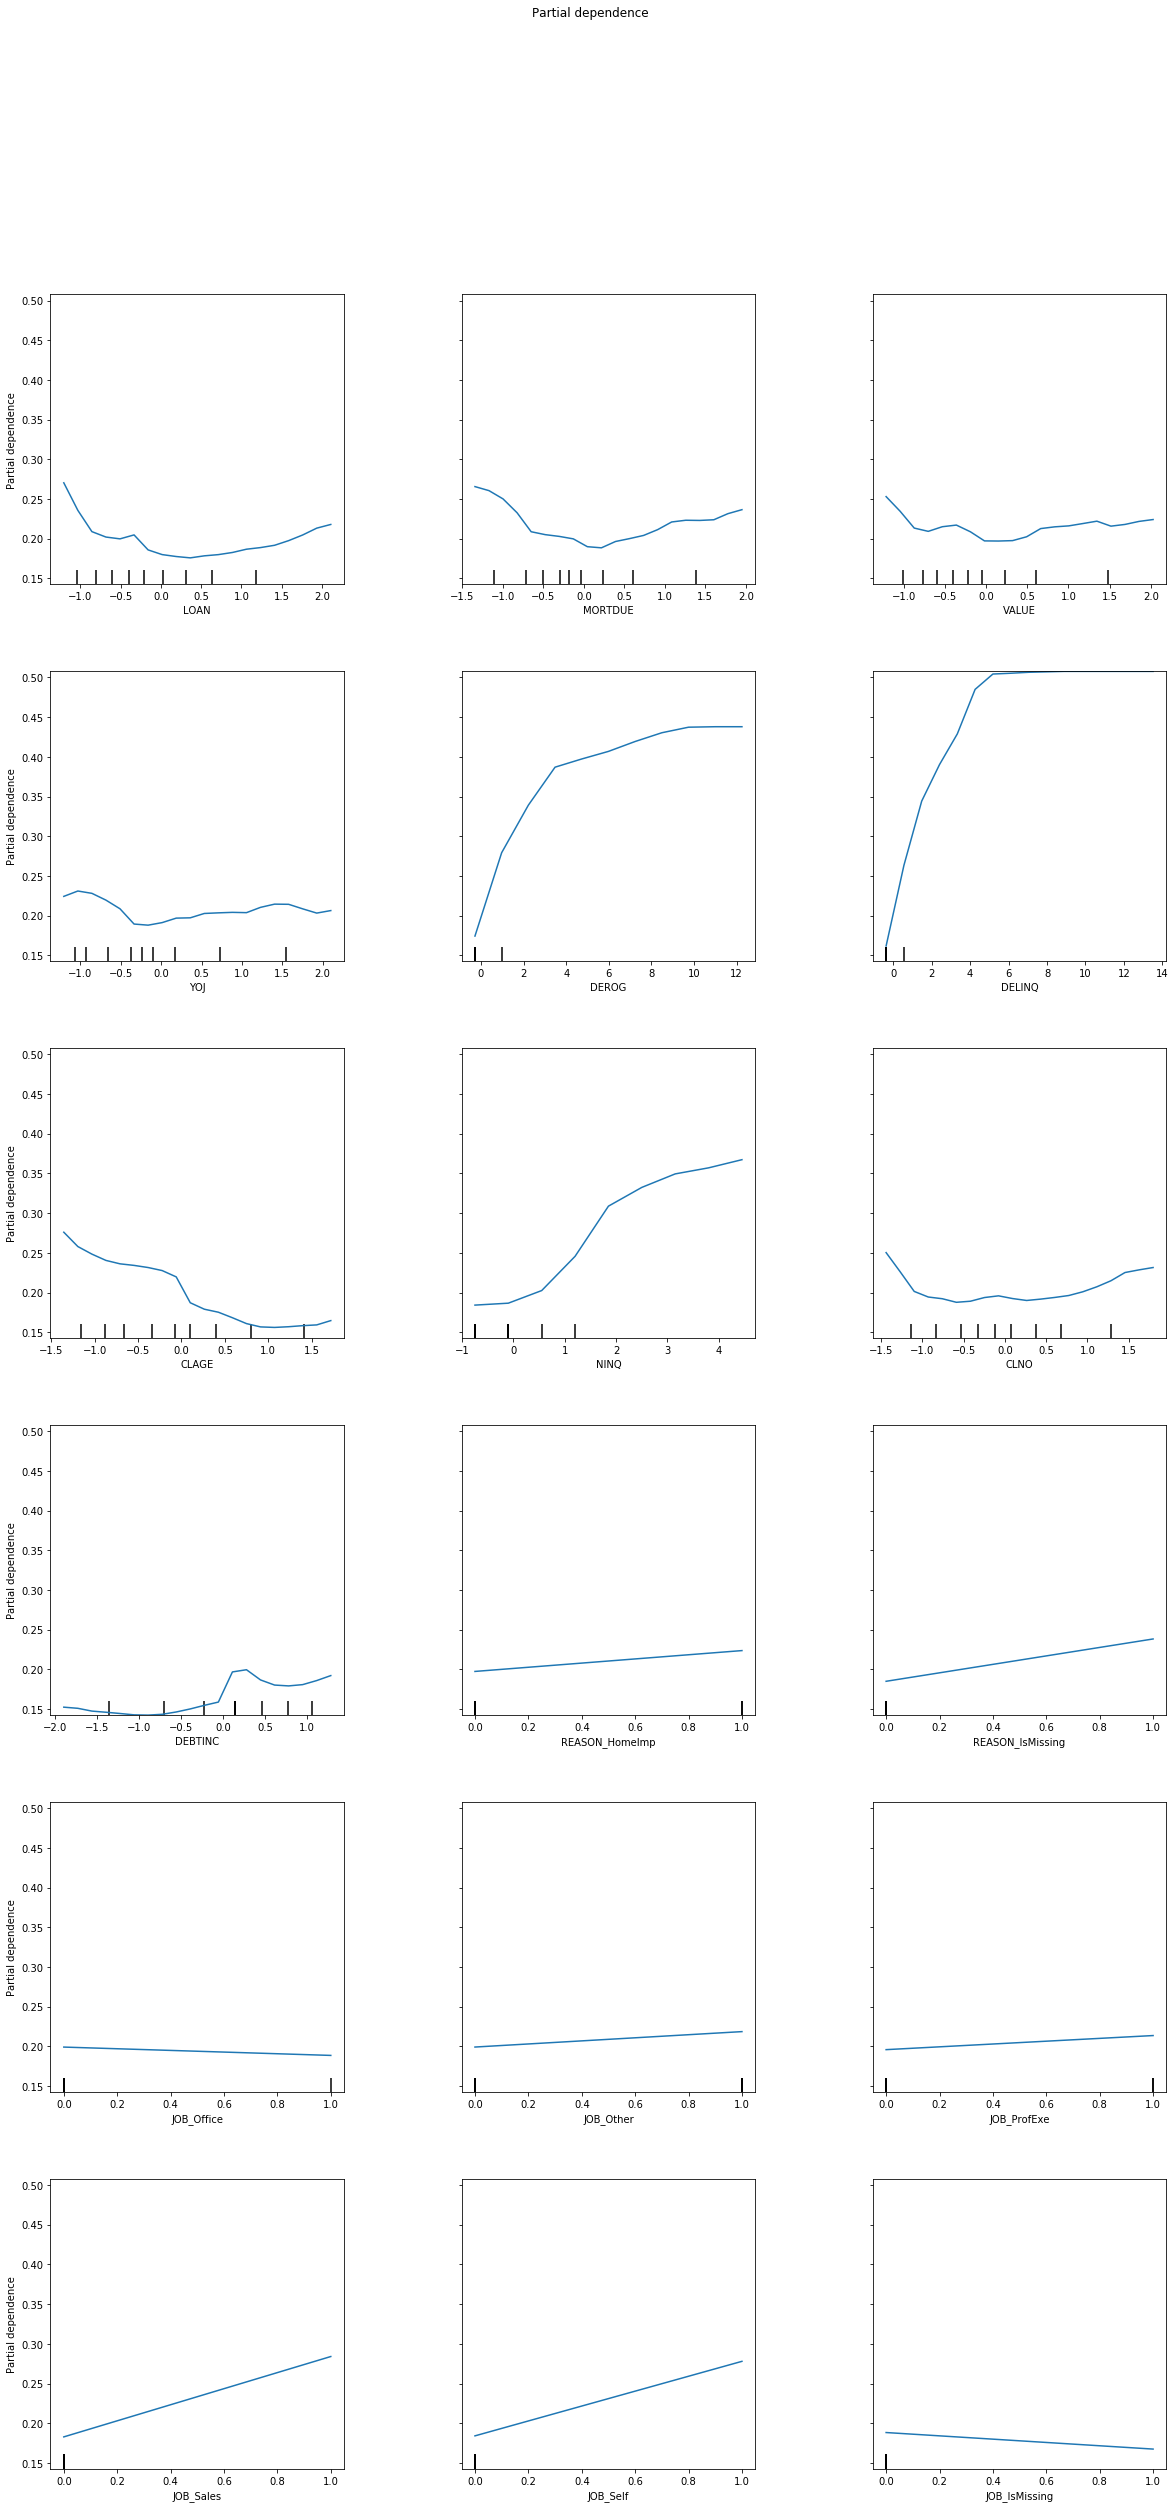

In [49]:
plt.rcParams['figure.figsize'] = 20,40
# Partial dependence
from sklearn.inspection import plot_partial_dependence
classifier = gs_rf.best_estimator_
print('Computing partial dependence plots...')
features = x_train.columns
plot_partial_dependence(classifier, x_train, features, n_jobs=3, grid_resolution=20)

fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()


Coming back to the question how CLAGE affects the PD estimates, we now have a clear answer. Higher values decrease PDs. That makes sense because high values indicate that a client has been with the bank for a longer time. We would expect such customers to be less likely to default compared to newer customers. 

As a cautionary remark, always make sure to know what exactely the y-axis is showing, the probability of being a good or a bad customer. In a binary classification setting, scikit-learn considers the class with the higher value the positive class. Here, BAD is a boolean variable. The class labels are stored as either true or false, which, when converted to an integer translates into 1 or zero.

In [265]:
y.head(5)

0     True
1     True
2     True
3     True
4    False
Name: BAD, dtype: bool

In [266]:
y.astype(int).head(5)

0    1
1    1
2    1
3    1
4    0
Name: BAD, dtype: int32

So the class encoded by True, that is the bad risks, or considered the positive class and their estimated probability is shown on the y-axis of the above PDP.